<a href="https://colab.research.google.com/github/Anisha234/Identifying-Tissue-of-Origin-From-miRNA/blob/main/miRNA_model_training_eval_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Necessary Imports for Model Training and Evaluation**

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

**Loading Data and Adding Appropriate Columns**

In [2]:
print(torch.cuda.is_available())
total_data = pd.read_csv('/content/full_miRNA_metadata_dataset_unnorm.csv')
sra_data = pd.read_csv('/content/SRA_data.csv')
sra_data=sra_data.astype({'disease_type': 'int64'})
#total_data = pd.read_csv('full_miRNA_meta_dataset_normalized.csv')
total_data.replace('False', 0, inplace=True)
#case_id column is unnecessary for our purposes
total_data=total_data.drop(columns='case_id')

# Convert meta data into the appropriate data types
total_data=total_data.astype({'disease_type': 'int64', 'gender': 'float32', 'age':'float32', 'sample_type':'int64'})
#bin age into 0-15 range
total_data['age'] = round(total_data['age']/0.5)+8
total_data['age'] =total_data['age'].clip(0,15)



False


<ipython-input-2-5fdef23a3074>:2: DtypeWarning: Columns (564) have mixed types. Specify dtype option on import or set low_memory=False.
  total_data = pd.read_csv('/content/full_miRNA_metadata_dataset_unnorm.csv')


In [3]:
total_data.shape

(9648, 566)

In [4]:
def transform_data(df, exclude_columns):
    data_part = df.loc[:, ~df.columns.isin(exclude_columns)]

    sum_row = data_part.sum(axis=1)
    data_part=data_part.div(sum_row, axis=0) * 1000000

    data_part = np.log(data_part+1.0)
    normalized_df=data_part


    for col in exclude_columns:
        normalized_df[col] = df[col]
    return normalized_df


In [6]:
#by modifying isin parameter, can change data used for training
#0 = primary tumor, 1 = solid normal, 2 = metastatic

train =total_data[total_data['sample_type'].isin([0,1])]

train = transform_data(train,['age','gender','disease_type','sample_type'])

#create a VALIDATION dataset --> part of tcga primary tumor samples
#set random state so that we have exact same state every time we run code
valid=train.sample(frac=0.1,random_state=200)
train=train.drop(valid.index) #remove all validation data from training set
train = train.sample(frac=1).reset_index(drop=True)
print(train.shape)

combined_test_set = total_data[total_data['sample_type'].isin([1,2])]
#perform a log transform on combined test set and sra.
combined_test_set = transform_data(combined_test_set, ['age','gender','disease_type','sample_type'])
sra_data = transform_data(sra_data, ['disease_type'])

solid_tissue_normal = combined_test_set[combined_test_set['sample_type'].isin([1])]
metastatic = combined_test_set[combined_test_set['sample_type']==2]

features_to_keep = pd.read_csv('miRNA_SRA_features.csv')
#only keeping mirna in training for which data is available in sra
X=train[list(features_to_keep['column'])]
X.drop(columns=['disease_type'], inplace=True)
# Drop features that are not present in the other set

print("Training dataset shape")
print(X.shape)
Y= train['disease_type']

X_valid=valid[list(features_to_keep['column'])]
X_valid.drop(columns=['disease_type'], inplace=True)
# Drop features that are not present in the other set
#print(X.head())
print("Validation dataset shape")
print(X_valid.shape)
Y_valid= valid['disease_type']

X_sra = sra_data[list(features_to_keep['column'])]
X_sra.drop(columns=['disease_type'], inplace=True)
Y_sra= sra_data['disease_type']

print("SRA dataset shape")
print(X_sra.shape)



X_solid_tissue_normal = solid_tissue_normal[list(features_to_keep['column'])]
X_solid_tissue_normal.drop(columns=['disease_type'], inplace=True)
Y_solid_tissue_normal= solid_tissue_normal['disease_type']
print("Solid tissue normal data shape:", X_solid_tissue_normal.shape)


X_metastatic= metastatic[list(features_to_keep['column'])]
X_metastatic.drop(columns=['disease_type'], inplace=True)
Y_metastatic = metastatic['disease_type']
print("Metastatic tissue data shape:", X_metastatic.shape)

X_combined_test_set = combined_test_set[list(features_to_keep['column'])]
X_combined_test_set.drop(columns=['disease_type'], inplace=True)
Y_combined_test_set= combined_test_set['disease_type']
print("Combined test set shape:", X_combined_test_set.shape)

#make a pie chart of all different types of cancers present in training set
disease_labels=["Breast", "Uterus", "Ovary", "Prostate", "Testis" ,"Lung", "Kidney","Bladder","Esophagus", "Liver","Pancreas","Pleura","Colorectal",
                "Skin", "Stomach","Brain", "Cervix", "Thyroid"]
disease_count = np.zeros(len(disease_labels))
for i in range(len(disease_labels)):
    disease_count[i] = sum(Y==i)


print(len(disease_labels))
#fig, ax = plt.subplots()
#ax.pie(disease_count, labels=disease_labels,  radius = 2.8, textprops={'fontsize':14})
#plt.show()

#print(sum(disease_count))
#print(disease_count)

(8355, 566)
Training dataset shape
(8355, 497)
Validation dataset shape
(928, 497)
SRA dataset shape
(194, 497)
Solid tissue normal data shape: (633, 497)
Metastatic tissue data shape: (365, 497)
Combined test set shape: (998, 497)
18


<ipython-input-6-80759e694c9a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['disease_type'], inplace=True)
<ipython-input-6-80759e694c9a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid.drop(columns=['disease_type'], inplace=True)
<ipython-input-6-80759e694c9a>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_sra.drop(columns=['disease_type'], inplace=True)
<ipython-input-6-80759e694c9a>:51: SettingWit

**Function to generate ROC curve**

In [7]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc, roc_curve
from itertools import cycle
import matplotlib.pyplot as plt
import math
from sklearn.metrics import RocCurveDisplay

def plot_roc_auc_for_class(y_onehot_test, y_onehot_pred_test, labels, class_index):
  n_classes=len(labels)

  fig, ax = plt.subplots(figsize=(6, 6))
  fpr, tpr, thresholds= roc_curve(y_onehot_test[:, class_index], y_onehot_pred_test[:,class_index])
  roc_auc = auc(fpr, tpr)

  print(f"ROC AUC score:\n{roc_auc:.3f}")
  print(roc_auc)
  ax.grid()
  ax.plot(
      fpr,
      tpr,
      label=f"ROC curve (AUC = {roc_auc:.3f})",
      color="navy",
      linestyle=":",
      linewidth=4,
  )
  ax.set(title='ROC curve for metastatic skin cancer samples')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  ax.legend([f"ROC curve (AUC = {roc_auc:.3f})"])
  plt.show()

def plot_roc_curves(y_onehot_test, y_onehot_pred_test, labels):
# store the fpr, tpr, and roc_auc for all averaging strategies
  n_classes=len(labels)
  fpr, tpr, roc_auc = dict(), dict(), dict()
  thresholds=dict()
  fig, ax = plt.subplots(figsize=(6, 6))
  for i in range(n_classes):
      fpr[i], tpr[i], thresholds[i] = roc_curve(y_onehot_test[:, i], y_onehot_pred_test[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  fpr_grid = np.linspace(0.0, 1.0, 1000)

  # Interpolate all ROC curves at these points
  mean_tpr = np.zeros_like(fpr_grid)
  class_cnt=0
  for i in range(n_classes):
      if not np.isnan(tpr[i]).any(): # np.isnan(fpr[i]):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
        print(i)
        class_cnt +=1

  # Average it and compute AUC
  mean_tpr /= class_cnt

  fpr["macro"] = fpr_grid
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.3f}")
  print(roc_auc)
  ax.grid()
  plt.plot(
      fpr["macro"],
      tpr["macro"],
      color="navy",
      linestyle=":",
      linewidth=4,
  )
  ax.set(title='ROC curve for combined test set')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  ax.legend([f"macro-average ROC curve (AUC = {roc_auc['macro']:.3f})"])
  plt.show()


## Classifier Implementation

In [8]:
def call_classifier(clf_name, X, Y, X_test1, Y_test1, X_test2, Y_test2, X_test3, Y_test3):
  '''
   Function takes training set and up to three test sets.
   Trains model and calculates accuracy of model on test sets.
   Plots a confusion matrix for each test set to visualize model performance.
  '''

  if clf_name == 'Random Forest':
    clf = RandomForestClassifier(n_estimators=128, max_depth=16)
  elif clf_name == 'Decision Tree':
    clf = DecisionTreeClassifier(max_depth=16)
  elif clf_name == 'Logistic Regression':
    clf = LogisticRegression(random_state=0, max_iter = 500)

  clf = clf.fit(X, Y)
  y_pred_train = clf.predict(X)
  y_pred1 = clf.predict(X_test1)
  y_pred2 = clf.predict(X_test2)
  y_pred3 = clf.predict(X_test3)

  acc_train=metrics.accuracy_score(Y, y_pred_train)
  acc_test1=metrics.accuracy_score(Y_test1, y_pred1)
  acc_test2 = metrics.accuracy_score(Y_test2, y_pred2)
  acc_test3 = metrics.accuracy_score(Y_test3, y_pred3)

  print(clf_name + ": Accuracy on train {:.3}, solid {:.3}, metastatic {:.3} SRA {:.3}".format(acc_train, acc_test1,
                                                                                               acc_test2, acc_test3))

  conf_matrix = confusion_matrix(Y_test1, y_pred1, labels=list(range(len(disease_labels))))
  fig, ax = plt.subplots(figsize=(8,6), dpi=100)
  display = ConfusionMatrixDisplay(conf_matrix,display_labels=disease_labels)
  ax.set(title='Confusion Matrix on solid normal samples: ' + clf_name)
  display.plot(ax=ax, xticks_rotation = 60)

  conf_matrix = confusion_matrix(Y_test2, y_pred2, labels=list(range(len(disease_labels))))
  fig, ax = plt.subplots(figsize=(8,6), dpi=100)
  display = ConfusionMatrixDisplay(conf_matrix,display_labels=disease_labels)
  ax.set(title='Confusion Matrix on metastatic samples: ' + clf_name)
  display.plot(ax=ax, xticks_rotation = 60)

  conf_matrix = confusion_matrix(Y_test3, y_pred3, labels=list(range(len(disease_labels))))
  fig, ax = plt.subplots(figsize=(8,6), dpi=100)
  display = ConfusionMatrixDisplay(conf_matrix,display_labels=disease_labels)
  ax.set(title='Confusion Matrix on samples from SRA: ' + clf_name)
  display.plot(ax=ax, xticks_rotation = 60)

  return clf

Call classifier function on Decision Tree, Random Forest, and Logistic Regression to observe classifier performance.

Decision Tree: Accuracy on train 0.983, solid 0.986, metastatic 0.581 SRA 0.428


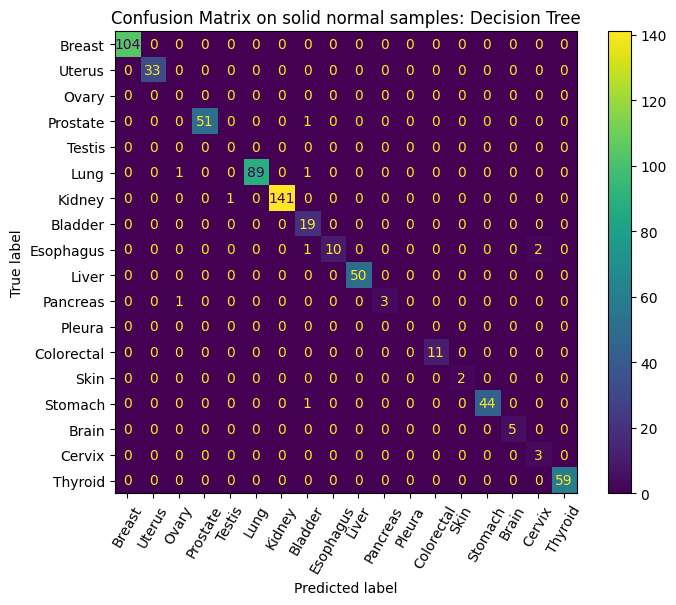

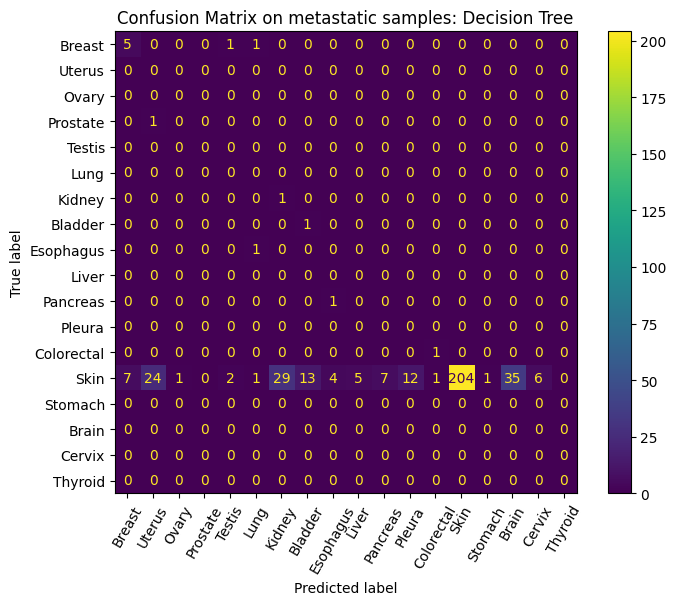

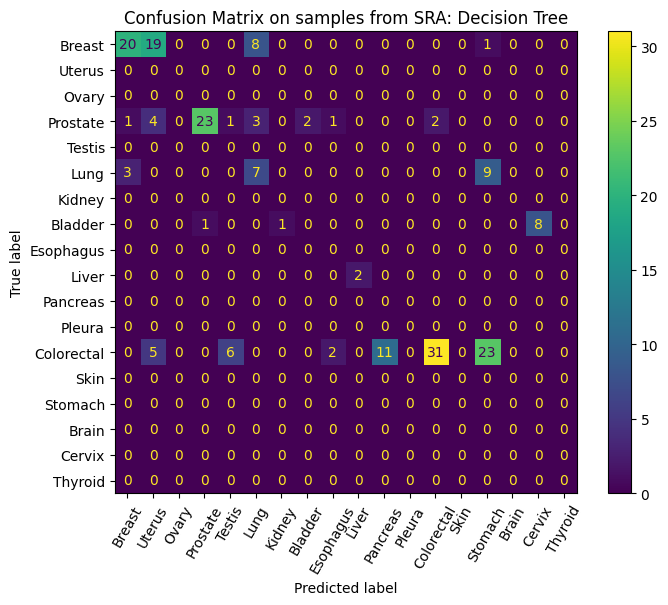

In [9]:
classifier = call_classifier("Decision Tree", X, Y, X_solid_tissue_normal, Y_solid_tissue_normal,
                             X_metastatic, Y_metastatic, X_sra, Y_sra)

Random Forest: Accuracy on train 1.0, solid 0.995, metastatic 0.942 SRA 0.686


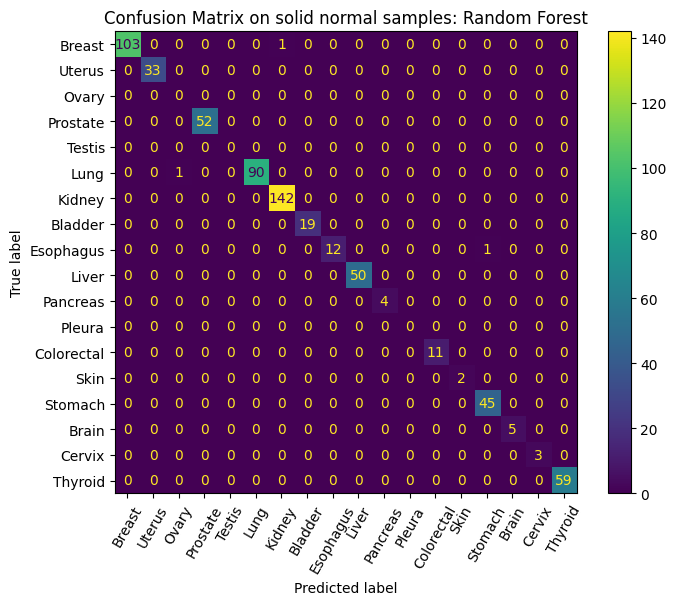

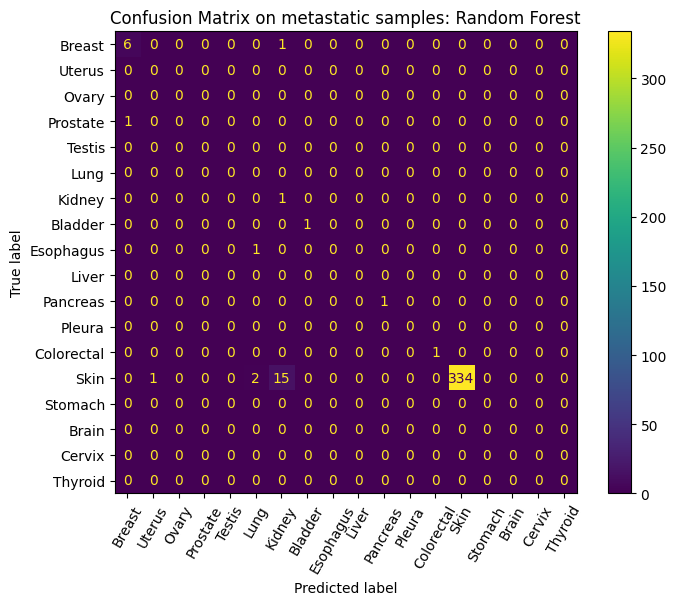

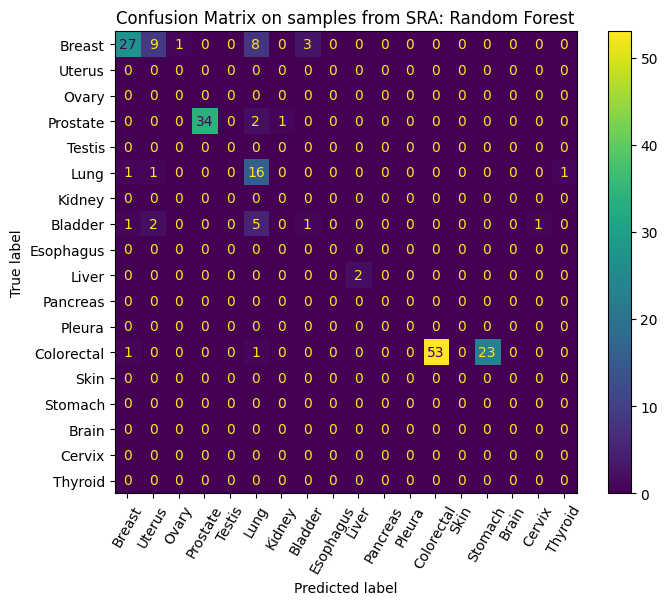

In [ ]:
classifier = call_classifier("Random Forest", X, Y, X_solid_tissue_normal, Y_solid_tissue_normal, X_metastatic, Y_metastatic, X_sra, Y_sra)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Accuracy on train 1.0, solid 0.998, metastatic 0.932 SRA 0.314


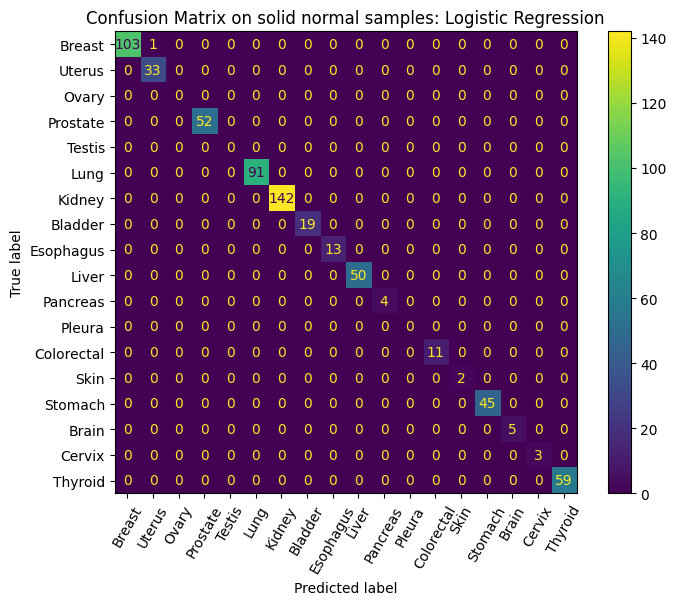

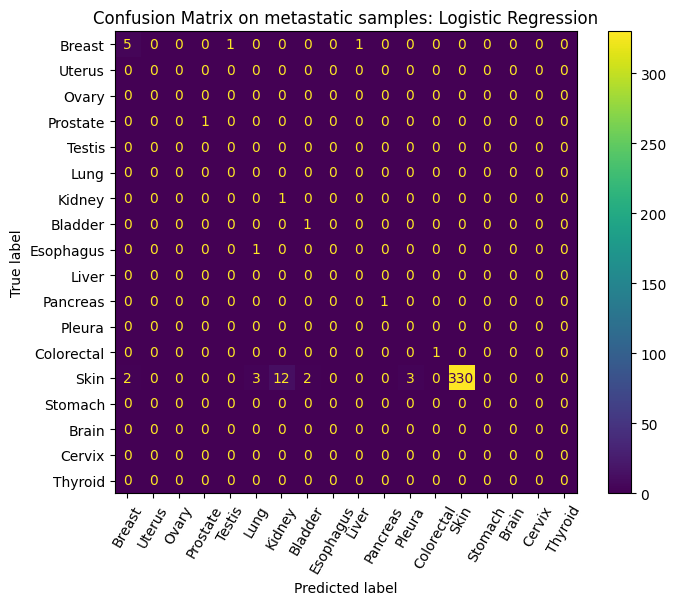

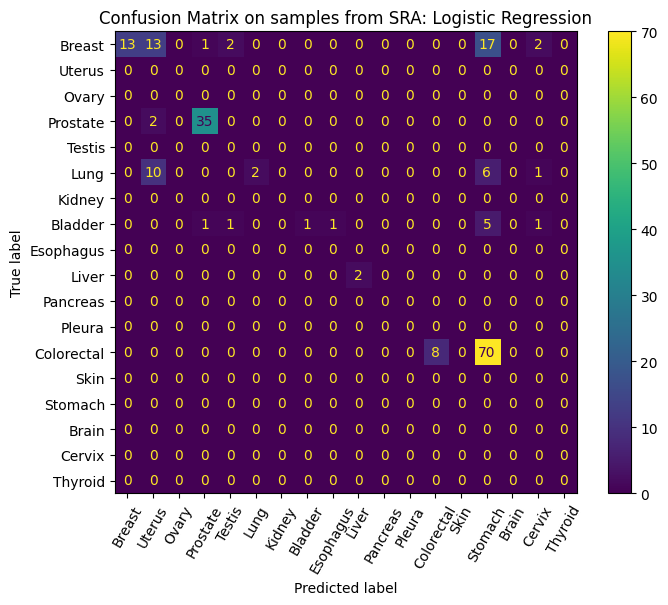

In [ ]:
classifier = call_classifier("Logistic Regression",X, Y, X_solid_tissue_normal, Y_solid_tissue_normal, X_metastatic, Y_metastatic, X_sra, Y_sra)

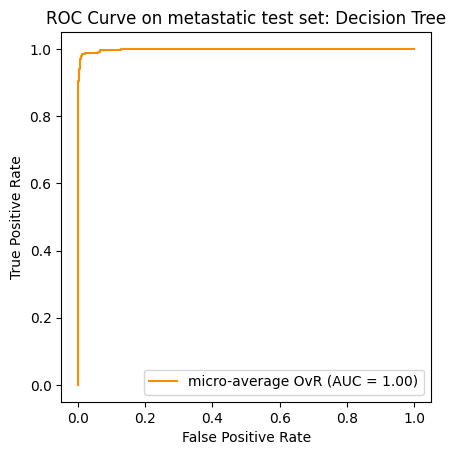

In [ ]:
label_binarizer = LabelBinarizer().fit(Y)
y_onehot_test = label_binarizer.transform(Y_metastatic)
y_onehot_pred_test = classifier.predict_proba(X_metastatic)

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_onehot_pred_test.ravel(),
    name="micro-average OvR",
    color="darkorange",

)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on metastatic test set: Decision Tree")
plt.legend()
plt.show()
#visualize performance of model on solely metastatic skin cancer samples:
#plot_roc_auc_for_class(y_onehot_test, y_onehot_pred_test, disease_labels, 13)

#plot roc curve
#plot_roc_curves(y_onehot_test, y_onehot_pred_test, disease_labels)

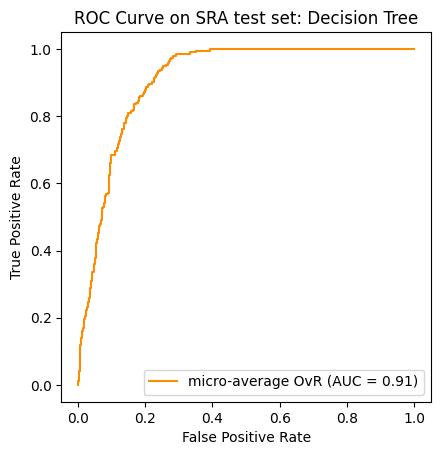

In [ ]:
label_binarizer = LabelBinarizer().fit(Y)
y_onehot_test = label_binarizer.transform(Y_sra)
y_onehot_pred_test = classifier.predict_proba(X_sra)

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_onehot_pred_test.ravel(),
    name="micro-average OvR",
    color="darkorange",

)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on SRA test set: Decision Tree")
plt.legend()
plt.show()
#visualize performance of model on solely metastatic skin cancer samples:
#plot_roc_auc_for_class(y_onehot_test, y_onehot_pred_test, disease_labels, 13)

#plot roc curve
#plot_roc_curves(y_onehot_test, y_onehot_pred_test, disease_labels)

## Permutation Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(classifier, X, Y,n_repeats=10, random_state=0)

KeyboardInterrupt: ignored

In [ ]:

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
       print(f"{X.columns[i]:<8}  "
             f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")


# Bar plot of importances
import pandas as pd
from matplotlib.pyplot import figure
cmap = plt.get_cmap('viridis')
colors = ['red','green','yellow'] #[cmap(i) for i in np.linspace(0, 1, len(X.columns))]
feat_importances = pd.Series(r.importances_mean, index = X.columns).sort_values(ascending = False)
feat_importances.nlargest(3).plot(kind = 'barh',color=colors)
plt.xlabel('Importance')
plt.ylabel('miRNA')


# Deep Learning Implementation

In [10]:

def predict(model, X_test_tensor, y_test_tensor):
  '''
  This function returns performance of model on a given test set
  '''

  output = model(X_test_tensor)
  output_idx = torch.argmax(output, dim=1)
  prob = torch.nn.functional.softmax(output)
  correct_cnt = torch.sum(output_idx==y_test_tensor)
  accuracy = correct_cnt/y_test_tensor.size()[0]

  return accuracy, output_idx, prob


In [29]:
#Creating class for the deep learning model
class network(nn.Module):
    def __init__(self,num_features, hidden, num_outputs, dropout):
        super(network, self).__init__()
        self.num_genes=num_features
        self.dropout = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(self.num_genes, 2*hidden)
        self.fc2 = nn.Linear(2*hidden, hidden)
        self.fc3 = nn.Linear(4*hidden,2*hidden)
        self.fc4 = nn.Linear(2*hidden,num_outputs)


    def forward(self, x):


        x1 = x[:,:self.num_genes]
        y = self.dropout(x1)
        y = self.fc1(y)
        y1= F.relu(y)
        y=y1
        y = self.fc2(y)
        return y
        y = F.relu(y)
        y = self.fc3(y)
        return y
        y = F.relu(y)
        y = self.fc4(y)
        return y


In [31]:
num_classes=len(disease_labels)
numRNA=X.shape[1]
dropout = 0.3
print("NUM CLASSES", num_classes)
print("NUM RNA", numRNA)
model = network(numRNA, num_classes, num_classes,dropout)

loss = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


#convert X_train, y_train, X_test, y_test to tensors
X_train_tensor = torch.tensor(X.to_numpy(),dtype=torch.float32)
y_train_tensor = torch.tensor(Y.to_numpy(),dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid.to_numpy(),dtype=torch.float32)
y_valid_tensor = torch.tensor(Y_valid.to_numpy(),dtype=torch.long)
X_sra_tensor = torch.tensor(X_sra.to_numpy(),dtype=torch.float32)
y_sra_tensor = torch.tensor(Y_sra.to_numpy(),dtype=torch.long)

X_solidnormal_tensor = torch.tensor(X_solid_tissue_normal.to_numpy(),dtype=torch.float32)
y_solidnormal_tensor = torch.tensor(Y_solid_tissue_normal.to_numpy(), dtype=torch.long)

X_metastatic_tensor = torch.tensor(X_metastatic.to_numpy(),dtype=torch.float32)
y_metastatic_tensor = torch.tensor(Y_metastatic.to_numpy(), dtype=torch.long)


#create lists to store the average losses over different epochs
train_loss_per_epoch_lst = []

acc_train_lst = []
acc_solidnormal_lst = []
acc_metastatic_lst = []

max_acc_valid = -1000


noise_scale = 0
model.train()

#TRAINING
batch_size=32
for k in range(0,10):
  loss_lst = [] #stores average losses per batch
  perm=torch.randperm(X_train_tensor.size()[0])
  X_train_tensor=X_train_tensor[perm,:]
  y_train_tensor=y_train_tensor[perm]
  for i in range(X_train_tensor.size()[0]//batch_size):

      batch_sample = X_train_tensor[batch_size*i:batch_size*(i+1),:]

      noise_sample = torch.rand(batch_sample.size())-0.5
      noise_sample = noise_sample*noise_scale # scaling the noise
      batch_sample = batch_sample+noise_sample

      batch_target = y_train_tensor[batch_size*i:batch_size*(i+1)]
      output = model(batch_sample)

      batch_loss = loss(output, batch_target)

      #calculate mean loss over batch, add to loss list
      l=torch.mean(batch_loss)
      loss_lst.append(l.detach().item())

      #back propagation - batch implementation is faster
       #calculate loss at the end of a batch
      l.backward()
      #updates the weights
      optimizer.step()
      #clear gradients of optimizer
      optimizer.zero_grad()

  avg = sum(loss_lst)/len(loss_lst)
  train_loss_per_epoch_lst.append(avg)

  #calculate performance on test set
  model.eval()
  with torch.no_grad():
    accuracy_valid,output_valid, _ = predict(model, X_valid_tensor, y_valid_tensor)
    accuracy_train,output_train,_ = predict(model, X_train_tensor, y_train_tensor)
    if max_acc_valid < accuracy_valid:
      max_acc_valid = accuracy_valid

      accuracy_solidnormal, output_solidnormal,_ = predict(model, X_solidnormal_tensor, y_solidnormal_tensor)
      accuracy_metastatic, output_metastatic,_ = predict(model, X_metastatic_tensor, y_metastatic_tensor)
      accuracy_sra, output_sra,_ = predict(model, X_sra_tensor, y_sra_tensor)

  print("Epoch {:2} train {:.3} valid {:.3} solid {:.3} meta {:.3} sra {:.3}".format(k, accuracy_train, accuracy_valid,
                                                                                          accuracy_solidnormal,
                                                                                          accuracy_metastatic, accuracy_sra))


  acc_solidnormal_lst.append(accuracy_solidnormal)
  acc_metastatic_lst.append(accuracy_metastatic)
  acc_train_lst.append(accuracy_train)
  model.train()




print(' accuracy on solid tissue set', accuracy_solidnormal)
print(' accuracy on metastatic set', accuracy_metastatic)
print(' accuracy on sra set', accuracy_sra)
print(' max validation accuracy ', max_acc_valid)

NUM CLASSES 18
NUM RNA 497


<ipython-input-10-a1031e7c5b3d>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = torch.nn.functional.softmax(output)


Epoch  0 train 0.777 valid 0.775 solid 0.796 meta 0.0192 sra 0.84
Epoch  1 train 0.882 valid 0.89 solid 0.836 meta 0.762 sra 0.83
Epoch  2 train 0.911 valid 0.914 solid 0.872 meta 0.948 sra 0.768
Epoch  3 train 0.917 valid 0.915 solid 0.88 meta 0.942 sra 0.789
Epoch  4 train 0.94 valid 0.932 solid 0.897 meta 0.964 sra 0.639
Epoch  5 train 0.932 valid 0.926 solid 0.897 meta 0.964 sra 0.639
Epoch  6 train 0.947 valid 0.932 solid 0.897 meta 0.964 sra 0.639
Epoch  7 train 0.946 valid 0.936 solid 0.907 meta 0.973 sra 0.634
Epoch  8 train 0.954 valid 0.942 solid 0.924 meta 0.953 sra 0.619
Epoch  9 train 0.955 valid 0.938 solid 0.924 meta 0.953 sra 0.619
 accuracy on solid tissue set tensor(0.9242)
 accuracy on metastatic set tensor(0.9534)
 accuracy on sra set tensor(0.6186)
 max validation accuracy  tensor(0.9418)










Creating a confusion matrix for deep learning model

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_metastatic_tensor, output_metastatic,labels=list(range(len(disease_labels))))
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(conf_matrix,display_labels=disease_labels)
ax.set(title='Confusion Matrix on metastatic samples: Deep Learning')
display.plot(ax=ax, xticks_rotation = 60)

conf_matrix = confusion_matrix(y_sra_tensor, output_sra, labels=list(range(len(disease_labels))))
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(conf_matrix,display_labels=disease_labels)
ax.set(title='Confusion Matrix on samples from SRA: Deep Learning')
display.plot(ax=ax, xticks_rotation = 60)

Create ROC curves for performance on SRA test set

In [ ]:
y_onehot_test = label_binarizer.transform(Y_sra)
_,_,y_onehot_pred_test = predict(model, X_sra_tensor , y_sra_tensor)
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_onehot_pred_test.detach().numpy().ravel(),
    name="micro-average OvR",
    color="darkorange",

)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on SRA test set: Deep Learning")
plt.legend()
plt.show()

Create ROC curves for performance on metastatic test set

In [ ]:
y_onehot_test = label_binarizer.transform(Y_metastatic)
_,_,y_onehot_pred_test = predict(model, X_metastatic_tensor , y_metastatic_tensor)
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_onehot_pred_test.detach().numpy().ravel(),
    name="micro-average OvR",
    color="darkorange",

)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on metastatic test set: Deep Learning")
plt.legend()
plt.show()